In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import gc
import pdet
import fpfs
import fitsio
import numpy as np
from fpfs import pltutil
import matplotlib.pylab as plt
import numpy.lib.recfunctions as rfn

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally

ver='try2'
gver='basic2'
dver='cut16'
wrkDir=os.environ['homeWrk']
simDir=os.path.join(wrkDir,'FPFS2/sim/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#nver='var1em9' # 'var0em0'#
nver='var7em3' # 'var0em0'#
#nver='var0em0' # 'var0em0'#
# read noiseless data
mm1=[]
mm2=[]
for _i in range(1024):
    _a1=fitsio.read(os.path.join(simDir,'srcfs3_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-0000.fits' %(gver,nver,ver,dver,_i)))
    _a2=fitsio.read(os.path.join(simDir,'srcfs3_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-2222.fits' %(gver,nver,ver,dver,_i)))
    mm1.append(_a1)
    mm2.append(_a2)
    del _a1,_a2#,msk1,msk2
mm1 =   rfn.stack_arrays(mm1,usemask=False)
mm2 =   rfn.stack_arrays(mm2,usemask=False)
gc.collect()

6

In [3]:
gc.collect()
Const  =   22.
noirev =   True
ellM1  =   fpfs.catalog.fpfsM2E(mm1,const=Const,noirev=noirev)
ellM2  =   fpfs.catalog.fpfsM2E(mm2,const=Const,noirev=noirev)
gc.collect()

0

/var/tmp/pbs.103078.idark/ipykernel_97207/4249344964.py:4: RuntimeWarning: invalid value encountered in log10
  m1   =   -2.5 * np.log10(mm1['fpfs_M00']) + 27.


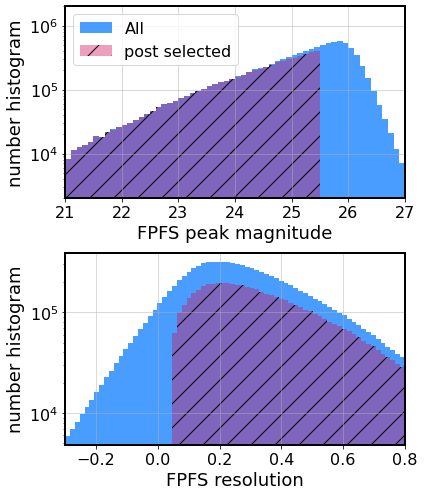

In [18]:
pix_scale=0.168
C=12.
nbins=70
m1   =   -2.5 * np.log10(mm1['fpfs_M00']) + 27.
r2   =   (mm1['fpfs_M20']+mm1['fpfs_M00'])/(mm1['fpfs_M00'])
msk=(m1<25.5)&(r2>=0.05)
plt.close()
fig,axes=pltutil.make_figure_axes(nx=1,ny=2,square=False)
ax=axes[0]
ax.hist(m1,bins=nbins,density=False,linewidth=2.,color=pltutil.colors[1],range=(20,27),\
        label='All',alpha=0.8,histtype='stepfilled')
ax.hist(m1[msk],bins=nbins,density=False,linewidth=2.,color=pltutil.colors[2],range=(20,27),\
        label='post selected',alpha=0.4,histtype='stepfilled',hatch='/')

#leg=ax.legend(loc='upper left',fontsize=20,handlelength=0,handletextpad=0,fancybox=False,markerscale=0)
#for it,text in enumerate(leg.get_texts()):
#    text.set_color(pltutil.colors[it+1])
ax.legend(loc='upper left',fontsize=16)
ax.set_xlim(21,27)
ax.set_ylim(2e3,2e6)
ax.set_yscale('log')
ax.set_xlabel('FPFS peak magnitude')
ax.set_ylabel('number histogram')
ax.grid()

ax=axes[1]
ax.hist(r2,bins=nbins,density=False,linewidth=2.,color=pltutil.colors[1],range=(-0.3,0.8),\
        alpha=0.8,histtype='stepfilled')
ax.hist(r2[msk],bins=nbins,density=False,linewidth=2.,color=pltutil.colors[2],range=(-0.3,0.8),\
        alpha=0.4,histtype='stepfilled',hatch='/')
ax.set_xlim(-0.3,0.8)
ax.set_yscale('log')
ax.set_xlabel('FPFS resolution')
ax.set_ylabel('number histogram')
ax.grid()
fig.tight_layout()


gc.collect()
fig.savefig('obsHist.pdf')

In [17]:
if False:
    del fs1,fs2
gc.collect()
use_sig=False
fs1=fpfs.catalog.summary_stats(mm1,ellM1,use_sig)
fs2=fpfs.catalog.summary_stats(mm2,ellM2,use_sig)

selnm=['R2']
dcc=0.1
cutB=-0.2
cutsig=[1.]

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,8):
    # clean outcome
    fs1.clear_outcomes()
    fs2.clear_outcomes()
    
    cut=cutB+dcc*i
    print(cut)
    cut=[cut]
    # weight array
    fs1.update_selection_weight(selnm,cut,cutsig);fs2.update_selection_weight(selnm,cut,cutsig)
    fs1.update_selection_bias(selnm,cut,cutsig);fs2.update_selection_bias(selnm,cut,cutsig)
    fs1.update_ellsum();fs2.update_ellsum()
    de   = fs2.sumE1-fs1.sumE1
    eA   = (fs1.sumE1+fs2.sumE1)/2.
    eAR  = (fs1.sumE1+fs2.sumE1+fs1.corE1+fs2.corE1)/2.
    rave = (fs1.sumR1+fs2.sumR1)/2.
    raveR= (fs1.sumR1+fs2.sumR1+fs1.corR1+fs2.corR1)/2.
    x.append(cut[-1])
    y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR/0.04)
    z1.append(eA/rave);z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR)

-0.2
-0.1
0.0
0.10000000000000003
0.2
0.3
0.4000000000000001
0.5


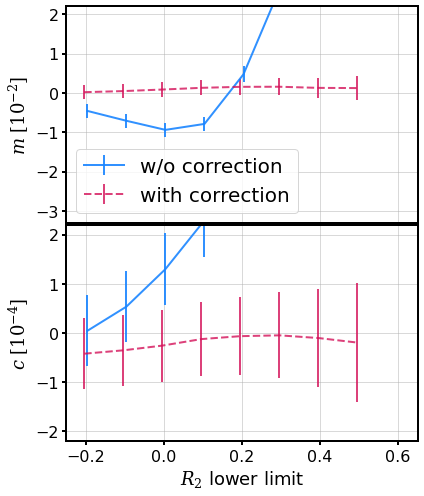

In [18]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$R_{2}$ lower limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.array(yerr)*1e2,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.array(yerr)*1e2,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(-0.25,0.65)
ax.set_ylim(-3.3,2.2)
ax.tick_params(width=2,size=4)
ax.set_xticklabels([])
ax.grid()
ax.legend()
ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(-0.25,0.65)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
#hist,bins=np.histogram(fs1.mm['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
#cbin=(bins[1:]+bins[:-1])/2.
#sf=hist.max()/2.
#hist=hist/sf
#ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()

plt.tight_layout(h_pad=-0.2)

In [5]:
#del fs1,fs2
gc.collect()
use_sig=False
fs1=fpfs.catalog.summary_stats(mm1,ellM1,use_sig)
fs2=fpfs.catalog.summary_stats(mm2,ellM2,use_sig)

selnm=['M00']
dcc=-0.6
cutB=27.
cutsig=[1.]

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,8):
    # clean outcome
    fs1.clear_outcomes()
    fs2.clear_outcomes()
    mcut=cutB+dcc*i
    cut=[10**((27-mcut)/2.5)]
    print(mcut,cut)
    # weight array
    fs1.update_selection_weight(selnm,cut,cutsig);fs2.update_selection_weight(selnm,cut,cutsig)
    fs1.update_selection_bias(selnm,cut,cutsig);fs2.update_selection_bias(selnm,cut,cutsig)
    fs1.update_ellsum();fs2.update_ellsum()
    de   = fs2.sumE1-fs1.sumE1
    eA   = (fs1.sumE1+fs2.sumE1)/2.
    eAR  = (fs1.sumE1+fs2.sumE1+fs1.corE1+fs2.corE1)/2.
    rave = (fs1.sumR1+fs2.sumR1)/2.
    raveR= (fs1.sumR1+fs2.sumR1+fs1.corR1+fs2.corR1)/2.
    x.append(mcut)
    y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR/0.04)
    z1.append(eA/rave);z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR)

27.0 [1.0]
26.4 [1.7378008287493778]
25.8 [3.0199517204020143]
25.2 [5.24807460249773]
24.6 [9.120108393559086]
24.0 [15.848931924611133]
23.4 [27.542287033381704]
22.8 [47.863009232263806]


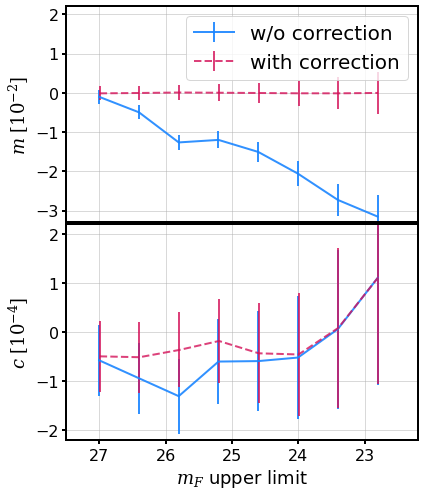

In [7]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$m_F$ upper limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.array(yerr)*1e2,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.array(yerr)*1e2,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(22.2,27.5)
ax.set_ylim(-3.3,2.2)
ax.tick_params(width=2,size=4)
ax.set_xticklabels([])
ax.grid()
ax.invert_xaxis()
ax.legend()
ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(22.2,27.5)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
#hist,bins=np.histogram(fs1.mm['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
#cbin=(bins[1:]+bins[:-1])/2.
#sf=hist.max()/2.
#hist=hist/sf
#ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()
ax.invert_xaxis()

plt.tight_layout(h_pad=-0.2)

In [24]:
if False:
    del fs1,fs2
gc.collect()
use_sig=False
fs1=fpfs.catalog.summary_stats(mm1,ellM1,use_sig)
fs2=fpfs.catalog.summary_stats(mm2,ellM2,use_sig)

selnm=['detect']
dcc=0.05
cutB=-0.05
cutsig=[0.2]

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,8):
    # clean outcome
    fs1.clear_outcomes()
    fs2.clear_outcomes()
    
    cut=cutB+dcc*i
    print(cut)
    cut=[cut]
    # weight array
    fs1.update_selection_weight(selnm,cut,cutsig);fs2.update_selection_weight(selnm,cut,cutsig)
    fs1.update_selection_bias(selnm,cut,cutsig);fs2.update_selection_bias(selnm,cut,cutsig)
    fs1.update_ellsum();fs2.update_ellsum()
    de   = fs2.sumE1-fs1.sumE1
    eA   = (fs1.sumE1+fs2.sumE1)/2.
    eAR  = (fs1.sumE1+fs2.sumE1+fs1.corE1+fs2.corE1)/2.
    rave = (fs1.sumR1+fs2.sumR1)/2.
    raveR= (fs1.sumR1+fs2.sumR1+fs1.corR1+fs2.corR1)/2.
    x.append(cut[-1])
    y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR/0.04)
    z1.append(eA/rave);z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR)

-0.05
0.0
0.05
0.10000000000000002
0.15000000000000002
0.2
0.25000000000000006
0.30000000000000004


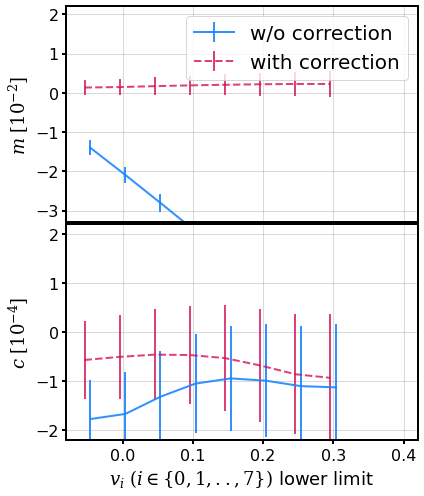

In [27]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$v_{i}~ {(i \in \{0,1,..,7\})}$ lower limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.array(yerr)*1e2,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.array(yerr)*1e2,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(-0.08,0.42)
ax.set_ylim(-3.3,2.2)
ax.tick_params(width=2,size=4)
ax.set_xticklabels([])
ax.grid()
ax.legend()
ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(-0.08,0.42)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
#hist,bins=np.histogram(fs1.mm['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
#cbin=(bins[1:]+bins[:-1])/2.
#sf=hist.max()/2.
#hist=hist/sf
#ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()

plt.tight_layout(h_pad=-0.2)

In [30]:
y2

[0.0013388994137808474,
 0.0014553073823020402,
 0.0016872026159231446,
 0.0018870102046413262,
 0.0020380311452090627,
 0.0021694590437373318,
 0.0022413373046406004,
 0.0022481495411275088]

In [23]:
0.006/0.168**2.

0.21258503401360543

(array([259419., 334950., 412104., 480538., 537885., 572469., 583892.,
        574050., 544780., 501368., 448994., 395952., 345009., 296412.,
        257103., 223338., 193462., 169152., 149163., 132967., 119150.,
        107355.,  96898.,  89095.,  81201.,  74569.,  68544.,  64445.,
         59485.,  55578.,  52115.,  48813.,  45759.,  43058.,  40624.,
         38209.,  36654.,  34445.,  32813.,  31183.,  29921.,  28328.,
         26787.,  25792.,  24684.,  23494.,  22583.,  21398.,  20430.,
         19728.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

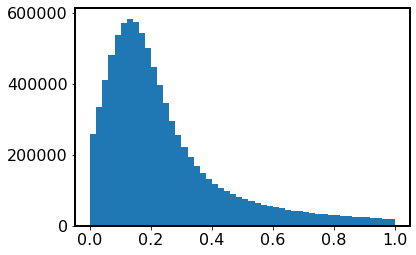

In [12]:
plt.hist(mm1['fpfs_v0'],range=(0,1),bins=50)